In [1]:
import torch
torch.cuda.empty_cache()


In [ ]:
import streamlit as st
import fitz
from nltk.tokenize import word_tokenize
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-3-mini-128k-instruct")
model = AutoModel.from_pretrained("microsoft/phi-3-mini-128k-instruct")
# model = SentenceTransformer("all-MiniLM-L6-v2")

model.eval()

def extract_from_pdf(uploaded_file):
    doc = fitz.open(stream=uploaded_file.read(), filetype="pdf")
    return "".join(page.get_text() for page in doc)

def make_chunks(text, chunk_size=512, overlap=50):
    words = text.split()   # <— simple whitespace split
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunks.append(" ".join(words[i:i + chunk_size]))
        if i + chunk_size >= len(words):
            break
    return chunks

def embed_text(chunks):
    # Tokenize and generate embeddings
    # inputs = tokenizer(chunks, padding=True, truncation=True, return_tensors="pt")
    # with torch.no_grad():
    #     outputs = model(**inputs)

    embeddings = model.encode(chunks, convert_to_numpy=True)
    return embeddings.tolist()

    # embeddings = outputs.last_hidden_state.mean(dim=1)
    # return embeddings.numpy().tolist()

def connect_to_database():
    if not connections.has_connection("default"):
        connections.connect(
            alias="default",
            uri="milvus_lite.db"
        )
    # return connections.get_connection("default")

def create_collection():
    id_field = FieldSchema(name="id", dtype=DataType.VARCHAR, is_primary=True, max_length=64)
    vector_field = FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=384)
    schema = CollectionSchema(fields=[id_field, vector_field], description="Document collection")

    collection_name = "Chunked_Docs"
    if not utility.has_collection(collection_name):
        collection = Collection(name=collection_name, schema=schema)
        collection.create_index(field_name="embedding", index_params={"index_type": "IVF_FLAT", "params": {"nlist": 128}})
        collection.load()
    else:
        collection = Collection(collection_name)
        collection.load()

    return collection

def upload_to_milvus(collection, uploaded_file):
    text = extract_from_pdf(uploaded_file)
    print(text)
    chunks = make_chunks(text)
    embeddings = embed_text(chunks)
    ids = [f"{uploaded_file.name}-{i}" for i in range(len(chunks))]

    try:
        collection.insert([ids, embeddings])
    except Exception as e:
        st.error(f"Error occurred: {str(e)}")

    
    st.write(f"Total documents in collection: {collection.num_entities}")
    st.success(f"{uploaded_file.name} uploaded and stored successfully!")

st.title("Upload Document & Store Embeddings in Milvus")

uploaded_file = st.file_uploader("Choose a PDF file", type=["pdf"])


if st.button("Upload File"):
    if uploaded_file:
        connect_to_database()
        collection = create_collection()
        upload_to_milvus(collection, uploaded_file)

        st.write("File type:", uploaded_file.type)
        st.write("File size (bytes):", uploaded_file.size)
    else:
        st.warning("Please select a file before uploading.")

In [8]:
from pymilvus import connections, Collection
import json

# Connect to Milvus
def connect_to_database():
    if not connections.has_connection("default"):
        connections.connect(
            alias="default",
            uri="milvus_lite.db"
        )

# Replace with your actual collection name
collection_name = "Chunked_Docs"
connect_to_database()
collection = Collection(collection_name)
collection.load()

# Fields you want to export
output_fields = ["id", "embedding"]  # Adjust if your schema uses different field names

# Get all data (adjust for large datasets)
results = collection.query(
    expr="",  # Empty means no filter – fetch all
    output_fields=output_fields,
    limit=1000  # Adjust limit as needed
)
import json
import numpy as np

# Example: format your data from Milvus query
formatted_data = {
    "collectionName": "Indian_Judgments",
    "dbName": "db_505c80f9dc0263a",
    "data": []
}

for record in results:
    formatted_data["data"].append({
         "primary_key": record["id"],
        "vector": [float(x) for x in record["embedding"]]  # Convert float32 to float
    })

# Save to JSON
with open("milvus_export.json", "w") as f:
    json.dump(formatted_data, f, indent=4)

print("✅ Exported to milvus_export.json")


print("✅ Exported to milvus_export.json")


✅ Exported to milvus_export.json
✅ Exported to milvus_export.json


In [ ]:
import json
import argparse
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def preprocess(example, tokenizer, max_length=512):
    return tokenizer(
        example['text'],
        truncation=True,
        padding='max_length',
        max_length=max_length
    )

def predict(model, tokenizer, dataset, device, batch_size=16):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    model.to(device)
    model.eval()

    predictions = {}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            ids = batch['id']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

            for _id, pred in zip(ids, preds):
                predictions[_id] = int(pred)

    return predictions

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_name', type=str, required=True, help='Hugging Face model path or ID')
    parser.add_argument('--output_file', type=str, required=True, help='Where to save the submission JSON')
    parser.add_argument('--max_length', type=int, default=512)
    parser.add_argument('--batch_size', type=int, default=16)
    args = parser.parse_args()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("🔄 Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(args.model_name)
    model = AutoModelForSequenceClassification.from_pretrained(args.model_name)

    print("📥 Loading IL-TUR Bail test dataset...")
    raw_dataset = load_dataset("Exploration-Lab/IL-TUR", "bail", split="test", revision="script")

    print("🧼 Tokenizing dataset...")
    tokenized_dataset = raw_dataset.map(
        lambda x: preprocess(x, tokenizer, args.max_length),
        batched=True
    )
    tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'id'])

    print("🚀 Running predictions...")
    predictions = predict(model, tokenizer, tokenized_dataset, device, args.batch_size)

    print(f"💾 Saving submission to {args.output_file}")
    submission = {"bail": predictions}
    with open(args.output_file, 'w', encoding='utf-8') as f:
        json.dump(submission, f, indent=2)

    print("✅ Done!")

if __name__ == "__main__":
    main()


In [3]:

import pandas as pd

df=pd.read_csv('Pedex_result.csv')
df

/tmp/ipykernel_1288076/3036228288.py:3: DtypeWarning: Columns (3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263

,Unnamed: 0,Input,Output,Label,Count,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 317,Unnamed: 318,Unnamed: 319,Unnamed: 320,Unnamed: 321,Unnamed: 322,Unnamed: 323,Unnamed: 324,Unnamed: 325,Nyayamitra_pred
0,0,emoluments for the purposes of computing Servi...,1[ds]The reliance on these instructions by the...,1,2023,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0\n ### Inst
1,1,deeply committed cannot function properly unle...,1[ds]107. On an analysis of the aforesaid aspe...,1,28380,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0. The appeal in
2,2,is that the Central Government shall not give ...,0[ds]18. Then in regard to the scope of the su...,0,6705,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0. The appeal in
3,3,for freight concession for iron ore exported f...,"0[ds]6. The promotion of trade and commerce, i...",0,12899,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0\n ### Order
4,4,regards 1he claim of interest on the unpaid pr...,1[ds]It has been held by the Trial Court i.e. ...,1,5134,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1. The appeal is
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,"C.V. Raman, Etc Vs. Management Of Bank Of Indi...",no such question arises in the instant cases w...,0[ds]In the instant cases we are not concerned...,0,7974,1880,0. The appeal in,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2806,Sheelkumar Jain Vs. New India Assurance Co. Ltd.,specified in Appendix-I to this scheme.” 10. T...,1[ds]The UCO Bank declined to accept his optio...,1,4392,780,0. The appeal in,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2807,"Divisional Forest Officer, Himachal Pradesh An...","to agriculture, or for pasture, and includes- ...",0[ds]In our opinion those cases are distinguis...,0,1851,486,0. The appeal in,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2808,State of Punjab &amp; Others Vs. Senior Vocati...,in the Rules. As far as nature of work is conc...,"0[ds]In the present case, the State Government...",0,6256,910,0. The appeal in,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df1=df[9:]

In [8]:
df2=pd.DataFrame()
df2['Case Name']=df1['Unnamed: 0']
df2['Input']=df1['Input']
df2['Output']=df1['Output']
df2['Label']=df1['Label']
df2['Nyayamitra_pred']=df1['Unnamed: 6']

In [10]:
df2.to_csv('Pedex_result_pred.csv',index=False)

In [13]:
df.isna().sum()

Case Name           0
Input             243
Output             10
Label               0
Count               0
Decision_Count      0
dtype: int64

In [14]:
df.dropna(inplace=True)

In [2]:
df = pd.read_csv('test.csv')
df

,Case Name,Input,Output,Label,Count,Decision_Count
0,State Of Madhya Pradesh &amp; Ors Vs. Seth Bal...,"Subba Rao, J.1. These two appeals by special l...",0[ds]6. As we are inclined to agree with the v...,0,4556,661
1,"Commissioner Of Income-Tax, Kerala And Coimbat...","Subba Rao, J.1. This appeal by special leave p...",0[ds]8. If that be the interpretation of S. 7 ...,0,4532,783
2,Imperial Tobacco Company of India Ltd Vs. Its ...,"Wanchoo, J.1. This appeal by special leave ari...",0[ds]4. There can be no doubt in this case tha...,0,1607,847
3,ZENITH DRUGS &amp; ALLIED AGENCIES PVT. LTD. R...,"R. BANUMATHI, J. 1. This appeal arises out of ...",1[ds]13. From a reading of the above terms of ...,1,4252,1189
4,PRAMOD KUMAR SINGH AND ORS Vs. STATE OF UTTAR ...,"Uday Umesh Lalit, J. 1. This petition under Ar...",0[ds]6. The process adopted by the State Gover...,0,2229,309
...,...,...,...,...,...,...
2796,"C.V. Raman, Etc Vs. Management Of Bank Of Indi...","OJHA, J. 1. These appeals raise an identical q...",0[ds]In the instant cases we are not concerned...,0,7974,1880
2797,Sheelkumar Jain Vs. New India Assurance Co. Ltd.,"A.K. PATNAIK, J. 1. Leave granted. 2. This is ...",1[ds]The UCO Bank declined to accept his optio...,1,4392,780
2798,"Divisional Forest Officer, Himachal Pradesh An...","Sikri, J. 1. This appeal by certificate grante...",0[ds]In our opinion those cases are distinguis...,0,1851,486
2799,State of Punjab &amp; Others Vs. Senior Vocati...,"R.K. Agrawal, J.1. The above appeal has been f...","0[ds]In the present case, the State Government...",0,6256,910


In [7]:
for i in range(len(li)):
    if li[i] is None:
        li[i]=''
        print(i)


In [7]:
print(li['Input'])

37    NaN
Name: Input, dtype: object


In [1]:
import pandas as pd

df=pd.read_csv("cleaned_combined_output.csv")
df

,meta_data,judgment,file_name
0,C.S.(Comm.Div).No.12 of 2021\n& O.A.Nos.394 & ...,3/5\nhttps://www.mhc.tn.gov.in/judis\nC.S.(Com...,616386.pdf
1,C.M.A.No.2432 of 2021\nIN THE HIGH COURT OF JU...,This Appeal has been filed by the Transport Co...,616396.pdf
2,C.M.A.No.2477 of 2021\nIN THE HIGH COURT OF JU...,This Appeal has been filed by the Transport Co...,616397.pdf
3,W.A. No. 2651 of 2021\nIN THE HIGH COURT OF JU...,(Judgment of the Court was delivered by S. VAI...,616398.pdf
4,C.M.A.No.843 of 2020\nIN THE HIGH COURT OF JUD...,"Appellants, who are the dependants of the dece...",616413.pdf
...,...,...,...
216596,S.A.No.532 of 2021 & CMP.No.11106 of 2021\nIN ...,The unsuccessful defendant before the Courts b...,613886.pdf
216597,CMP.No.11899 of 2021 in\nAs.Sr.No.44900 of 202...,The above application is filed by a 3rd party ...,614076.pdf
216598,C.S.No.267 of 2021\nIN THE HIGH COURT OF JUDIC...,"Today when the matter is taken up for hearing,...",615154.pdf
216599,S.A.No.1288 of 2009\nIN THE HIGH COURT OF JUDI...,(Heard through Video Conferencing)\nThis Secon...,616041.pdf


In [2]:
li=list(df['file_name'])

In [7]:
for i in range(len(li)):
    if li[i] =='13723.pdf':
        print(i)

10397


In [5]:
li.sort()

In [19]:
print(li[9010])

12333.pdf


In [2]:
df.isna().sum()

meta_data    0
judgment     0
file_name    0
dtype: int64

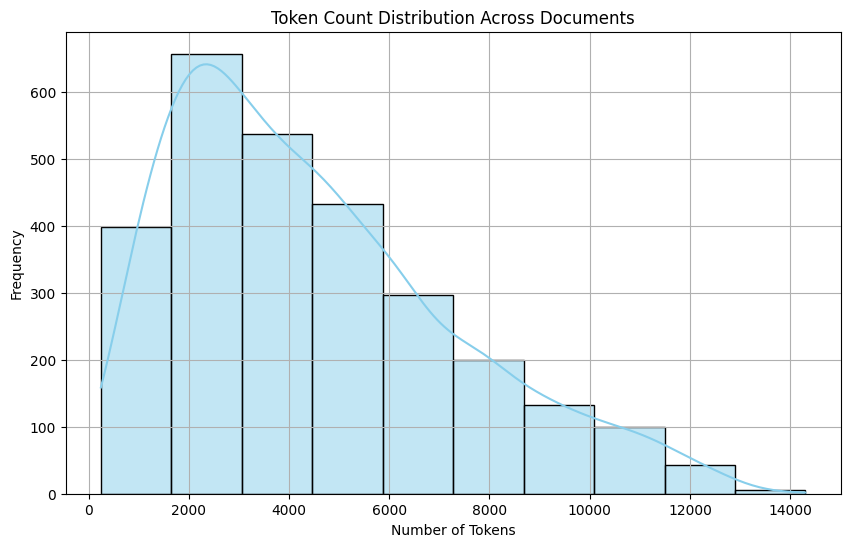

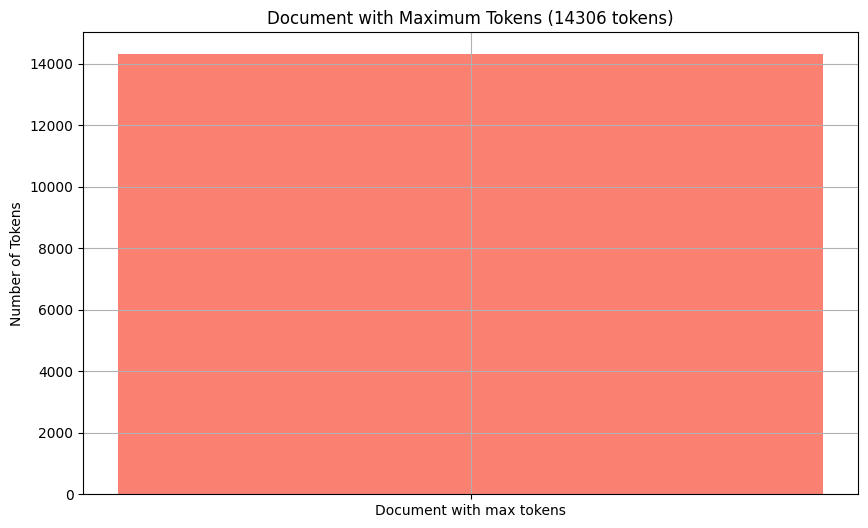

Document with max tokens: Bhan, J. 1. We propose to dispose of these appeals as has been done by the High Court, by a common order, as the point involved in all these appeals is the same. 2. Facts are taken from Civil Appeal No. 7115 of 2005. 3. Commissioner of Income Tax, Delhi-I, the respondent herein, filed ITA No. 340 of 2004 in the High Court of Delhi against the order passed by the Income Tax Appellate Tribunal (for short "the Tribunal") under Section 260A of the Income Tax Act. Assessee also filed ITA No........... of 2004 being aggrieved against a part of the order of the Tribunal. High Court allowed the ITA No. 340 of 2004 filed by the Revenue and held that the Tribunal was not right in deleting the penalty imposed under Section 271(1)(c) of the Income Tax Act, 1961 (for short "the Act") merely on the ground that the total income of the assessee was assessed at a minus figure/loss. Tribunal had allowed the assessees appeal remitting the penalty imposed by the assessing officer

In [5]:
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Replace this with the correct model name for phi3-mini
model_name = "Srinivastl/NyayaMitra"  # This is an example name, replace with the actual model name

# Load the tokenizer for phi3-mini
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example dataset (list of strings)
df=pd.read_csv("test.csv")
dataset=list(df['Input'])

token_counts = [len(tokenizer.encode(doc)) for doc in dataset]

# Plot 1: Token Count Distribution (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(token_counts, bins=10, kde=True, color="skyblue")
plt.title("Token Count Distribution Across Documents")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot 2: Maximum Token Count (Bar Chart)
max_tokens = max(token_counts)
max_index = token_counts.index(max_tokens)

plt.figure(figsize=(10, 6))
plt.bar(["Document with max tokens"], [max_tokens], color="salmon")
plt.title(f"Document with Maximum Tokens ({max_tokens} tokens)")
plt.ylabel("Number of Tokens")
plt.grid(True)
plt.show()

# Optionally, you can display the text of the document with the maximum tokens
print(f"Document with max tokens: {dataset[max_index]}")


In [6]:
from pymilvus import Collection, CollectionSchema, FieldSchema, DataType, connections, utility
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# -----------------------------
# Step 1: Connect to Milvus
# -----------------------------
def connect_to_database():
    if not connections.has_connection("default"):
        connections.connect(
            alias="default",
            uri="milvus_lite.db"
        )

connect_to_database()

# -----------------------------
# Step 2: Define Milvus Collection
# -----------------------------
collection_name = "squad_contexts"
embedding_dim = 384  # For MiniLM

# Define schema
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=1000),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=embedding_dim),
]
schema = CollectionSchema(fields, description="SQuAD contexts for RAG")

# Create collection if not exists
if collection_name not in utility.list_collections():
    collection = Collection(name=collection_name, schema=schema)
    print(f"✅ Created collection: {collection_name}")
else:
    collection = Collection(collection_name)
    print(f"ℹ️ Using existing collection: {collection_name}")

# -----------------------------
# Step 3: Load SQuAD Data
# -----------------------------
print("📦 Loading SQuAD dataset...")
dataset = load_dataset("squad", split="train[:1000]")  # You can increase size
contexts = list(set([ex["context"] for ex in dataset]))  # Deduplicate contexts

# -----------------------------
# Step 4: Load Embedder
# -----------------------------
print("🔍 Loading embedding model...")
embedder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
embedder.eval()

def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = embedder(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings.squeeze().cpu().numpy()

# -----------------------------
# Step 5: Embed and Insert
# -----------------------------
print("🚀 Inserting into Milvus...")
BATCH_SIZE = 50
texts, vectors = [], []


for i, context in enumerate(tqdm(contexts)):
    truncated = context[:1000]  # Truncate text to max VARCHAR length
    vector = embed_text(truncated)
    texts.append(truncated)
    vectors.append(vector)
    if len(texts) == BATCH_SIZE or i == len(contexts) - 1:
        collection.insert([texts, vectors])
        texts, vectors = [], []

# -----------------------------
# Step 6: Finalize
# -----------------------------
collection.flush()
collection.load()
print(f"✅ Inserted {len(contexts)} contexts into Milvus collection '{collection_name}'")


ℹ️ Using existing collection: squad_contexts
📦 Loading SQuAD dataset...
🔍 Loading embedding model...
🚀 Inserting into Milvus...


100%|██████████| 119/119 [00:01<00:00, 62.13it/s]

✅ Inserted 119 contexts into Milvus collection 'squad_contexts'


In [1]:
from pymilvus import Collection, connections
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModel, AutoModelForCausalLM
from datasets import load_dataset
import torch
import numpy as np
from tqdm import tqdm

# -----------------------------------------
# Step 1: Connect to Milvus and Load Collection
# -----------------------------------------
def connect_to_database():
    if not connections.has_connection("default"):
        connections.connect(
            alias="default",
            uri="milvus_lite.db"
        )

connect_to_database()
collection = Collection("squad_contexts")
from pymilvus import Index

# Build index on 'embedding' field
index_params = {
    "index_type": "IVF_FLAT",       # or "HNSW", "IVF_SQ8", etc.
    "metric_type": "L2",            # or "COSINE" or "IP" (must match search config)
    "params": {"nlist": 128}        # nlist controls index granularity
}

index = Index(
    collection,
    "embedding",
    index_params
)

print("✅ Index created successfully.")
collection.load()

# -----------------------------------------
# Step 2: Load Models
# -----------------------------------------
print("🔍 Loading models...")
embedder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
embedder.eval()
embed_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

generator =  AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-128k-instruct")
gen_tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")
generator.eval()
# -----------------------------------------
# Step 3: Embedding and Retrieval Functions
# -----------------------------------------
def embed_query(query: str) -> np.ndarray:
    inputs = embed_tokenizer(query, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = embedder(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

def retrieve_context(query: str, top_k=5):
    embedding = embed_query(query)
    results = collection.search(
        data=[embedding],
        anns_field="embedding",
        param={"metric_type": "L2", "params": {"nprobe": 10}},
        limit=top_k,
        output_fields=["text"]
    )
    return [hit.entity.text for hit in results[0]]

def generate_answer(query: str, contexts: list):
    prompt = f"question: {query} context: {' '.join(contexts)}"
    inputs = gen_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        output_ids = generator.generate(**inputs, max_new_tokens=100)
    return gen_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# -----------------------------------------
# Step 4: Load SQuAD Questions for Evaluation
# -----------------------------------------
print("📦 Loading SQuAD questions...")
dataset = load_dataset("squad", split="train[:100]")  # Sample subset

# -----------------------------------------
# Step 5: Evaluation (Exact Match and F1)
# -----------------------------------------
def compute_f1(pred, gold):
    pred_tokens = pred.lower().split()
    gold_tokens = gold.lower().split()
    common = set(pred_tokens) & set(gold_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gold_tokens)
    return 2 * precision * recall / (precision + recall)

exact_matches, f1s = [], []

print("🚀 Running evaluation...")
for example in tqdm(dataset):
    query = example["question"]
    true_answer = example["answers"]["text"][0].strip()

    contexts = retrieve_context(query)
    generated = generate_answer(query, contexts).strip()

    em = int(generated.lower() == true_answer.lower())
    f1 = compute_f1(generated, true_answer)

    exact_matches.append(em)
    f1s.append(f1)

# -----------------------------------------
# Step 6: Report Metrics
# -----------------------------------------
print("\n=== RAG Evaluation Results ===")
print(f"Exact Match: {np.mean(exact_matches):.2f}")
print(f"Average F1 Score: {np.mean(f1s):.2f}")


✅ Index created successfully.
🔍 Loading models...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

📦 Loading SQuAD questions...
🚀 Running evaluation...


100%|██████████| 100/100 [2:27:08<00:00, 88.29s/it] 



=== RAG Evaluation Results ===
Exact Match: 0.00
Average F1 Score: 0.01
